## Load packages

In [95]:
%pylab inline
import pandas as pd
import pydot
from scipy.stats import binom_test
import seaborn as sns
import scipy.stats as stats
import itertools

Populating the interactive namespace from numpy and matplotlib



## Load data

**Note**, this data is after removing people who failed catch 
question and 4 people for which there was a technical software error. 

In [108]:
df = pd.read_csv('/Users/tomer/Dropbox/Turking/minimal turing/publishedVersion/data/exp2_data.csv')

### An explanation of variable names and ordering:

Participants were given word pairs according to the dictionary below (wordDic). 

For example, wordPair[26] = 8|10 and wordChosen[26] = 10.  
This means participant #26 saw the pair human|alive (in that order),  
and chose 'alive' as the word likely coming from the human


In [104]:
wordDic =   {'1' : 'poop',
             '2' : 'robot', 
             '3' : 'banana',
             '4' : 'love',
             '5' : 'compassion',
             '6' : 'empathy',
             '7' : 'please',
             '8' : 'human',
             '9' : 'mercy',
             '10' : 'alive',}

words = ['poop', 'robot','banana', 'love', 'compassion',
         'empathy', 'please','human', 'mercy', 'alive']


## Basic demographics

In [78]:
gender = df["gender"].values
age = df["age"].values
print "Participants who identified as women:", sum([x==2 for x in gender])
print "Participants who identified as men:", sum([x==1 for x in gender])
print "Mean age was:", round(nanmean(age)), ", ranging from", nanmin(age), "to", nanmax(age)

Participants who identified as women: 918
Participants who identified as men: 1153
Mean age was: 33.0 , ranging from 18.0 to 74.0


In [112]:
# baseChosen = df["base"]
# baseOrder = df["DO-Q-base"]

wordChosen = df["wordChosen"]
wordPair = df["wordPair"]

## Analysis

In [123]:
## Construct a 10x10 array corresponding to the words in their order
## as defined in wordDic, with each entry indicating the number of
## people that chose that word when presented with a pair

## That is, if rawJudgeMat[i,j] = N, it means N people chose i as the word coming
## from the human when presented with the choice of wordDic[i], wordDic[j]
rawJudgeMat = zeros([10,10])

for i, wp in enumerate(wordPair.values):
    sortedWp = sort([int(x) for x in wp.split('|')])
    currentWord = int(wordChosen.values[i])
    if currentWord == sortedWp[0]:
        rawJudgeMat[sortedWp[0]-1,sortedWp[1]-1] += 1
    elif currentWord == sortedWp[1]:
        rawJudgeMat[sortedWp[1]-1,sortedWp[0]-1] += 1

### Average agreement & Binomial tests per word pair

In [161]:
numBinomialPass = 0
agreementPercentage = []
for i in range(10):
    for j in range(i+1,10):
        numParticipantsInThisPair = rawJudgeMat[i,j]+rawJudgeMat[j,i]
        numParticipantsAgree = max(rawJudgeMat[i,j],rawJudgeMat[j,i])
        agreementPercentage.append(numParticipantsAgree/numParticipantsInThisPair*100)
        if stats.binom_test(numParticipantsAgree,numParticipantsInThisPair,p=0.5)<0.05:
            numBinomialPass +=1
print "Mean Agreement across 45 pairs", round(mean(agreementPercentage),1), "%"
print "SD",round(std(agreementPercentage),1)
print "===="
print "#pairs for which there was sig. agreement by binomail test:", numBinomialPass

Mean Agreement across 45 pairs 70.0 %
SD 9.5
====
#pairs for which there was sig. agreement by binomail test: 29


## Create Fig 2.A

In [174]:
## Reorder the raw judgement matrix such that matrix rows go from 
## 'strongest' to 'weakest' word, roughly 

reorder = array([0,3,6,8,4,5,2,9,7,1])
wordsRevised = ['poop', 'love','please', 'mercy', 'compassion',
                     'empathy', 'banana','alive', 'human', 'robot']

## Create a 'relative strength' matrix. 
## An entry relativeStrengthMat[i,j] = P means that P% of judges
## choose i over j as coming from the human

relativeStrengthMat = copy(rawJudgeMat)

for i in range(10):
    relativeStrengthMat[i,:] = rawJudgeMat[reorder[i],:][reorder]
for i in range(10):
    for j in range(i+1,10):
        relativeStrengthMat[i,j] = 100*round(float(relativeStrengthMat[i,j]) / (relativeStrengthMat[i,j] + relativeStrengthMat[j,i]),2)
        relativeStrengthMat[j,i] = 100 - relativeStrengthMat[i,j]


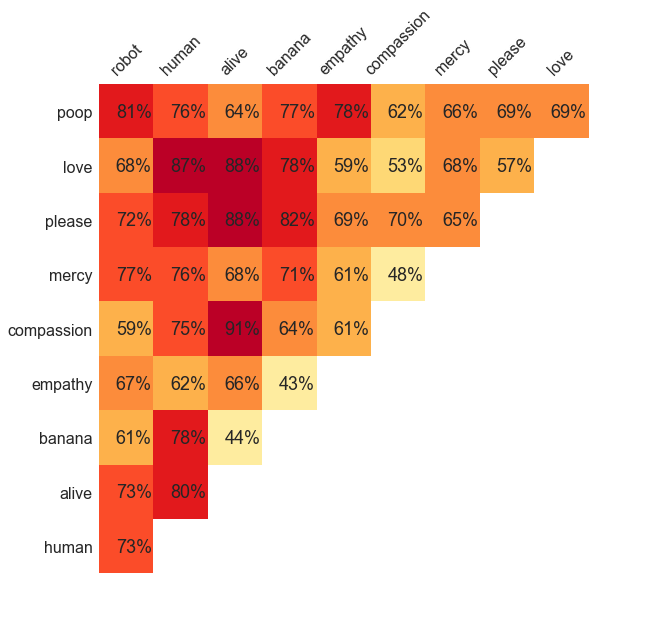

In [199]:
## Set the diagonal and under to be NaN as we will be cutting them out
## as the diagonal is obviously nan and the matrix is symmetric so info
## under the diagonal is superfluous. 
for i in range(10):
    for j in range(i+1,10):
        relativeStrengthMat[j,i] = NaN
    relativeStrengthMat[i,i] = NaN

figsize(10,10)
with sns.axes_style("white"):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    

## plot
cmap2 = mpl.colors.ListedColormap(sns.color_palette("YlOrRd", n_colors=7))
ax.imshow(fliplr(relativeStrengthMat), interpolation='nearest', origin="upper",cmap=cmap2)
for i, row in enumerate(fliplr(relativeStrengthMat)):
    for j, c in enumerate(row):
        if j<9-i and c>0:
            text(j-0.2, i+0.1, str(int(c))+'%', fontsize = 18)

## use words as labels
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.xaxis.tick_top()
ax.set_xticklabels(wordsRevised[::-1][0:-1],fontsize=16,rotation=45)
ax.set_yticklabels(wordsRevised[0:-1],fontsize=16,rotation=0)

## remove box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#savefig("judgeturingmatrix.eps")

## Create Fig 2.B

In [204]:
## This creates the figure locally rather than displaying 
## it inline due to the use of pydot. 

PATH_TO_FIGURE2B = "../figures/figure2B"

graph = pydot.Dot(graph_type="digraph")
nedge = 0

## Loop over words. 
## If the agreement is significant by a binomial test
## then create an edge between the two word-nodes
## scale edge width by agreement
for i,w1 in enumerate(words):
    for j,w2 in enumerate(words[(i+1):]):
        v1 = rawJudgeMat[i,j+i+1]
        v2 = rawJudgeMat[j+i+1,i]
        pw = 4*abs(v1-v2)/(v1+v2)
        if binom_test(rawJudgeMat[i,j+i+1], rawJudgeMat[i,j+i+1] + rawJudgeMat[j+i+1,i]) <0.05:
            nedge = nedge +1
            if rawJudgeMat[i,j+i+1] > rawJudgeMat[j+i+1,i]:
                edge = pydot.Edge(w1, w2, penwidth=pw)
                graph.add_edge(edge)
            elif rawJudgeMat[i,j+i+1] < rawJudgeMat[j+i+1,i]:
                edge = pydot.Edge(w2, w1, penwidth=pw)
                graph.add_edge(edge)
                
graph.write_pdf(PATH_TO_FIGURE2B + ".pdf")
graph.write_svg(PATH_TO_FIGURE2B + ".svg")
    
## There is some post-processing of this figure using vector-graphics software
## to make it more legible. 

## Cyclic analysis 

Check how many graphs are DAGs

We have nodes=numNodes (10 in our paper), edges=numEdges (29 in our paper).  
We pick two nodes at random and draw an edge between them, then remove that  
pair from the list of 'possible pairs'. Repeat this selection for 29 edges.  
Then run a 'cyclical?' check on the resulting graph. 

Tests: numEdges = 1, numNodes = 2 should return 0 cycles.  
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       numEdges = 3, numEdges = 3 should return 25% cycles. 



In [205]:
def cyclic(g):
    """Return True if the directed graph g has a cycle.
    g must be represented as a dictionary mapping vertices to
    iterables of neighbouring vertices. For example:

    >>> cyclic({1: (2,), 2: (3,), 3: (1,)})
    True
    >>> cyclic({1: (2,), 2: (3,), 3: (4,)})
    False

    """
    path = set()

    def visit(vertex):
        path.add(vertex)
        for neighbour in g.get(vertex, ()):
            if neighbour in path or visit(neighbour):
                return True
        path.remove(vertex)
        return False

    return (visit(v) for v in g)

In [208]:
tot = []


numEdges = 29
numNodes = 10
sampleSize = 100000
for N in range(sampleSize):
    if N%1000==0:
        print N/float(sampleSize),
    possibleEdges = [x for x in itertools.combinations(range(numNodes),2)]
    temp = copy(possibleEdges)
    for e in temp:
        possibleEdges.append(tuple(e[::-1].tolist()))
    edges = []
    for i in range(numEdges):
        currentEdge = possibleEdges[random.choice(range(len(possibleEdges)))]
        edges.append(currentEdge)
        reverseCurrentedge = currentEdge[::-1]
        possibleEdges.remove(currentEdge)
        possibleEdges.remove(reverseCurrentedge)
    g = {}
    for i in range(numNodes):
        temp = [x[1] for x in edges if x[0]==i]
        if len(temp)>0:
            g[i] = tuple(temp)
    tot.append(any(list(cyclic(g))))
    
print "\nOut of ", sampleSize, " graphs, ", sum(tot), " were cyclical"
print "Cycle estimate: ", float(sum(tot))/sampleSize

0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 
Out of  100000  graphs,  99928  were cyclical
Cycle estimate:  0.99928
